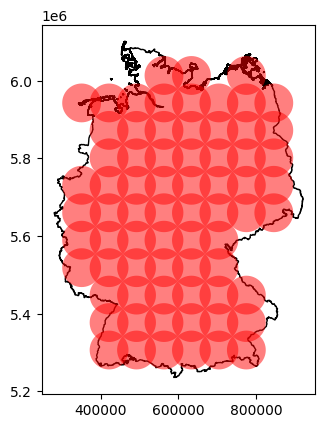

In [10]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd

def create_circular_grid(minx, miny, maxx, maxy, radius, crs):
    # Create a grid of points
    x_coords = np.arange(minx, maxx, radius * np.sqrt(2))
    y_coords = np.arange(miny, maxy, radius * np.sqrt(2))
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]

    # Buffer the points to create circles
    grid_circles = [point.buffer(radius) for point in grid_points]

    # Get the centroids of the circles
    centroids = [circle.centroid for circle in grid_circles]

    # Convert the centroids to the specified CRS
    centroids = gpd.GeoSeries(centroids, crs=crs)

    return gpd.GeoDataFrame(geometry=grid_circles), centroids

def plot_circular_grid(filepath, radius_km, crs):
    # Load geopackage and convert to a projected CRS (UTM zone 32N for country)
    gdf = gpd.read_file(filepath)
    gdf = gdf.to_crs('EPSG:32632')

    # Get the total bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # Convert radius to meters
    radius_m = radius_km * 1000
    grid_gdf, centroids = create_circular_grid(minx, miny, maxx, maxy, radius_m, crs)

    # Remove circles that are completely outside of the area
    grid_gdf = grid_gdf[grid_gdf.geometry.intersects(gdf.unary_union)]

    #remove circles whose centroid is outside the borders of country and updates the gird_gdf and centroids
    grid_gdf = grid_gdf[grid_gdf.centroid.intersects(gdf.unary_union)]

    # Now you can plot it
    fig, ax = plt.subplots(1, 1)
    gdf.plot(ax=ax, color='white', edgecolor='black')
    grid_gdf.plot(ax=ax, color='red', alpha=0.5)  # alpha is for transparency
    plt.show()

    return grid_gdf, centroids

# Example usage:
crs = 'EPSG:4326'  # WGS 84
grid_gdf, centroids = plot_circular_grid('gadm36_DEU.gpkg', 50, crs)


#########################################

In [13]:
def cover_uncovered_areas(grid_gdf, germany, radius_km, total_uncovered=None, prev_uncovered=None):
    # Create a union of all the circle polygons
    circle_union = grid_gdf.geometry.unary_union

    # Perform a geometric difference operation
    uncovered_areas = germany.geometry.unary_union.difference(circle_union)

    # Convert the uncovered areas to a GeoSeries and explode it
    uncovered_areas = gpd.GeoSeries(uncovered_areas)
    uncovered_areas = uncovered_areas.explode(index_parts=True)

    # If this is the first call to the function, set the total number of uncovered areas
    if total_uncovered is None:
        total_uncovered = len(uncovered_areas)
        print(f'Total uncovered areas: {total_uncovered}')

    if uncovered_areas.empty:
        return grid_gdf

    if not uncovered_areas.empty:
        # Get the first uncovered area
        first_uncovered_area = uncovered_areas.iloc[0]

        # Calculate the centroid of the first uncovered area
        centroid = first_uncovered_area.centroid

        #check if the centroid is within Germany
        if germany.geometry.unary_union.contains(centroid):
            # Create a new GeoDataFrame for the centroid
            new_gdf = gpd.GeoDataFrame(geometry=[centroid.buffer(radius_km * 1000)])
            # Concatenate the new GeoDataFrame with the original one
            grid_gdf = pd.concat([grid_gdf, new_gdf], ignore_index=True)
        
        #recalculate the circle union and the uncovered areas
        circle_union = grid_gdf.geometry.unary_union
        uncovered_areas = germany.geometry.unary_union.difference(circle_union)
        uncovered_areas = gpd.GeoSeries(uncovered_areas)
        uncovered_areas = uncovered_areas.explode(index_parts=True)
        print("remaining uncovered areas: " + str(len(uncovered_areas)))

    # Break the recursion if the number of uncovered areas does not decrease
    if prev_uncovered is not None and len(uncovered_areas) >= prev_uncovered:
        print("Cannot cover more areas. Breaking the recursion.")
        return grid_gdf

    if not uncovered_areas.empty:
        grid_gdf = cover_uncovered_areas(grid_gdf, germany, radius_km, total_uncovered, len(uncovered_areas))

    if uncovered_areas.empty:
        return grid_gdf

# Call the function
result = cover_uncovered_areas(grid_gdf, germany, radius_km)

# Print the result
print(result)


NameError: name 'germany' is not defined